In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Read Iamges and Create Dataset

In [139]:
# Root directory for dataset
dataroot_T2 = "./BraTS2015_Medium/T2/train"
dataroot_OT = "./BraTS2015_Medium/OT/train"
dataroot_OT_Back = "./BraTS2015_Medium/OT_BACKGROUND/train"

dataroot_T2_test = "./BraTS2015_Medium/OT/test"
dataroot_OT_test = "./BraTS2015_Medium/OT/test"
dataroot_OT_Back_test = "./BraTS2015_Medium/OT_BACKGROUND/test"

# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 25

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

#   size of fixed noise
fixed_noise_size = 25

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 800

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [140]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset_T2 = dset.ImageFolder(root=dataroot_T2,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
dataset_OT = dset.ImageFolder(root=dataroot_OT,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
dataset_OT_Back = dset.ImageFolder(root=dataroot_OT_Back,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

dataset_OT_Back_test = dset.ImageFolder(root=dataroot_OT_Back_test,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

In [6]:
class CustomerDataset(Dataset):

    def __init__(self, ds1, ds2):
        super(CustomerDataset, self).__init__()
        self.ds1 = [ds1[index][0] for index in range(len(ds1))]
        self.ds2 = [ds2[index][0] for index in range(len(ds2))]

    def __len__(self):
        return len(self.ds1)

    def __getitem__(self, index): 
        
        return self.ds1[index], self.ds2[index]


In [10]:
ds =  CustomerDataset(dataset_T2, dataset_OT_Back)

In [11]:
dataloader = torch.utils.data.DataLoader(ds, batch_size=batch_size,pin_memory=True,timeout=0,
                                         shuffle=True, num_workers=workers)

In [12]:
for i, (ds1, ds2),  in enumerate(dataloader):  
    print(i, len(ds1), len(ds2))

0 25 25
1 25 25
2 25 25
3 25 25
4 25 25
5 25 25
6 25 25
7 25 25
8 25 25
9 25 25
10 25 25
11 25 25
12 25 25
13 25 25
14 25 25
15 25 25
16 25 25
17 25 25
18 25 25
19 25 25
20 25 25
21 25 25
22 25 25
23 25 25
24 25 25
25 25 25
26 25 25
27 25 25
28 25 25
29 25 25
30 25 25
31 25 25
32 25 25
33 25 25
34 25 25
35 25 25
36 25 25
37 25 25
38 25 25
39 25 25
40 25 25
41 25 25
42 25 25
43 25 25
44 25 25
45 25 25
46 25 25
47 25 25
48 25 25
49 25 25
50 25 25
51 25 25
52 25 25
53 25 25
54 25 25
55 25 25
56 25 25
57 25 25
58 25 25
59 25 25
60 25 25
61 25 25
62 25 25
63 25 25
64 25 25
65 25 25
66 25 25
67 25 25
68 25 25
69 25 25
70 25 25
71 25 25
72 25 25
73 25 25
74 25 25
75 25 25
76 25 25
77 25 25
78 25 25
79 25 25
80 25 25
81 25 25
82 25 25
83 25 25
84 25 25
85 25 25
86 25 25
87 25 25
88 25 25
89 25 25
90 25 25
91 25 25
92 25 25
93 25 25
94 25 25
95 25 25
96 25 25
97 25 25
98 25 25
99 25 25
100 25 25
101 25 25
102 25 25
103 25 25
104 25 25
105 25 25
106 25 25
107 25 25
108 25 25
109 25 25
110 25 25


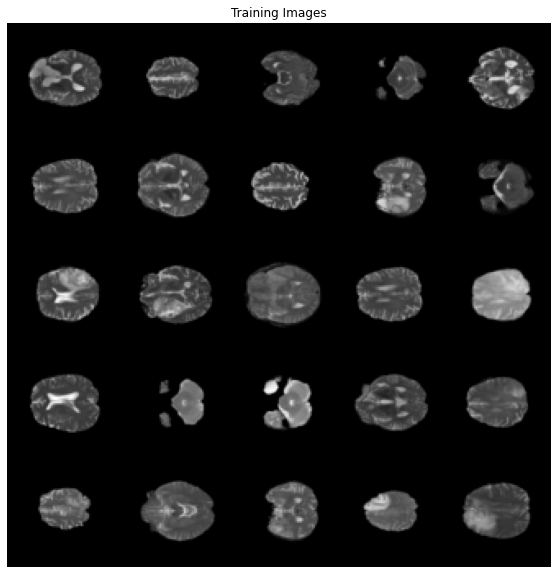

In [158]:

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:25], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

## Create the Model

In [14]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [122]:
class Encoder(nn.Module):
    def __init__(self, ngpu):
        super(Encoder, self).__init__()
        self.ngpu = ngpu  
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, nz, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
         
        

    def forward(self, input):
        return self.main(input)

In [123]:

class Decoder(nn.Module):
    def __init__(self, ngpu):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [124]:
# Create the Discriminator
netEncoder = Encoder(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netEncoder = nn.DataParallel(netEncoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netEncoder.apply(weights_init)

# Print the model
print(netEncoder)

Encoder(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 100, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [125]:
# Create the Discriminator
netDecoder = Decoder(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netDecoder = nn.DataParallel(netDecoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netDecoder.apply(weights_init)

# Print the model
print(netDecoder)

Decoder(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [126]:
# Initialize MSELoss function
mesloss = torch.nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(fixed_noise_size, nz, 1, 1, device=device)

#  the progression of the generator
selected_index = np.random.randint(len(ds), size=fixed_noise_size)
fixed_ot_image = torch.stack([ds[i][1] for i in selected_index]).to(device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerDecoder = optim.Adam(netDecoder.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerEncoder = optim.Adam(netEncoder.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

In [127]:
# Training Loop

# Lists to keep track of progress
img_list = [] 
losses = []

iters = 0
netDecoder
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data_t2, data_ot) in enumerate(dataloader, 0):

        
        
        ############################
        # (1) Update Encoder network:  
        ############################
        ## Train with all-real batch
        
        real_cpu = data_ot.to(device)
        #print("real_cpu.shape", real_cpu.shape)
        b_size = real_cpu.size(0)
        
        netEncoder.zero_grad()
        netDecoder.zero_grad()
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        representation = netEncoder(real_cpu).view(b_size,-1,1,1)
        #print(representation.shape)
        
        output = netDecoder(representation).view(real_cpu.shape)
        
        # Calculate loss on all-real batch 
        err = mesloss(output, real_cpu)
        
        # Calculate gradients for G
        err.backward()
        D_x = err.mean().item()
        
        # Update 
        optimizerDecoder.step()
        optimizerEncoder.step()
        
         

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f\tD(x): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err.item(), D_x))

        # Save Losses for plotting later
        losses.append(err.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            images_to_plot = torch.cat((real_cpu, output), dim=0).cpu()
            #print(images_to_plot.shape)
            img_list.append(vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5))

        iters += 1

Starting Training Loop...
[0/800][0/127]	Loss: 1.0575	D(x): 1.0575
[0/800][50/127]	Loss: 0.1223	D(x): 0.1223
[0/800][100/127]	Loss: 0.0443	D(x): 0.0443
[1/800][0/127]	Loss: 0.0391	D(x): 0.0391
[1/800][50/127]	Loss: 0.0218	D(x): 0.0218
[1/800][100/127]	Loss: 0.0138	D(x): 0.0138
[2/800][0/127]	Loss: 0.0157	D(x): 0.0157
[2/800][50/127]	Loss: 0.0109	D(x): 0.0109
[2/800][100/127]	Loss: 0.0099	D(x): 0.0099
[3/800][0/127]	Loss: 0.0100	D(x): 0.0100
[3/800][50/127]	Loss: 0.0077	D(x): 0.0077
[3/800][100/127]	Loss: 0.0083	D(x): 0.0083
[4/800][0/127]	Loss: 0.0070	D(x): 0.0070
[4/800][50/127]	Loss: 0.0069	D(x): 0.0069
[4/800][100/127]	Loss: 0.0065	D(x): 0.0065
[5/800][0/127]	Loss: 0.0074	D(x): 0.0074
[5/800][50/127]	Loss: 0.0052	D(x): 0.0052
[5/800][100/127]	Loss: 0.0067	D(x): 0.0067
[6/800][0/127]	Loss: 0.0059	D(x): 0.0059
[6/800][50/127]	Loss: 0.0049	D(x): 0.0049
[6/800][100/127]	Loss: 0.0049	D(x): 0.0049
[7/800][0/127]	Loss: 0.0045	D(x): 0.0045
[7/800][50/127]	Loss: 0.0040	D(x): 0.0040
[7/800][1

[63/800][100/127]	Loss: 0.0009	D(x): 0.0009
[64/800][0/127]	Loss: 0.0007	D(x): 0.0007
[64/800][50/127]	Loss: 0.0009	D(x): 0.0009
[64/800][100/127]	Loss: 0.0007	D(x): 0.0007
[65/800][0/127]	Loss: 0.0008	D(x): 0.0008
[65/800][50/127]	Loss: 0.0008	D(x): 0.0008
[65/800][100/127]	Loss: 0.0008	D(x): 0.0008
[66/800][0/127]	Loss: 0.0007	D(x): 0.0007
[66/800][50/127]	Loss: 0.0007	D(x): 0.0007
[66/800][100/127]	Loss: 0.0007	D(x): 0.0007
[67/800][0/127]	Loss: 0.0007	D(x): 0.0007


KeyboardInterrupt: 

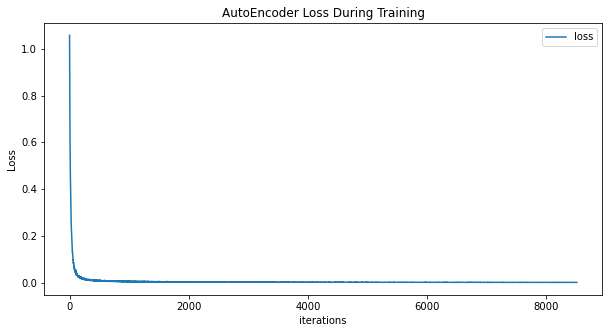

In [157]:
plt.figure(figsize=(10,5))
plt.title("AutoEncoder Loss During Training")
plt.plot(losses,label="loss")
#plt.plot(D_losses,label="Encoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

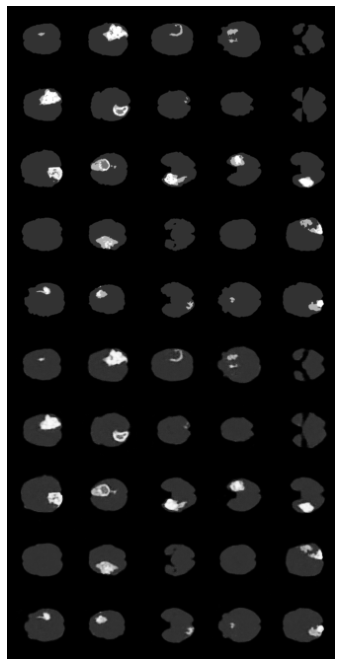

In [130]:
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.detach().numpy(),(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Check the result on Testing set 

In [143]:

selected_index = np.random.randint(len(dataset_OT_Back_test), size=fixed_noise_size)
fixed_OT_image = torch.stack([dataset_OT_Back_test[i][0] for i in selected_index]).to(device)

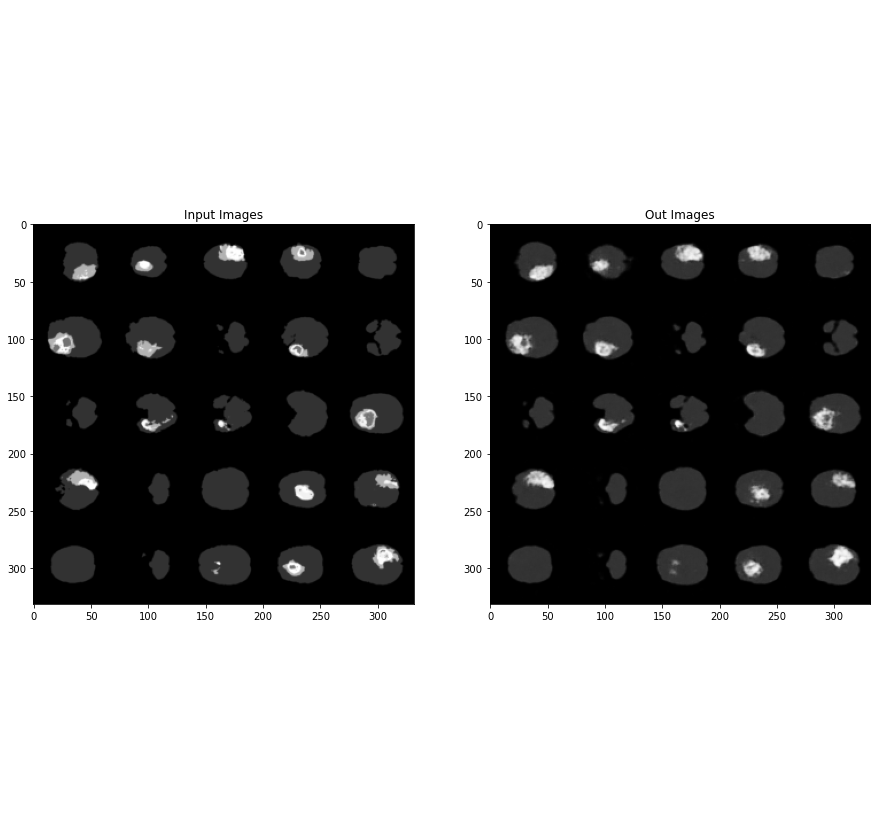

In [155]:
with torch.no_grad():
    real_cpu = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = real_cpu.size(0)

    # Since we just updated D, perform another forward pass of all-fake batch through D 
    representation = netEncoder(real_cpu).view(b_size,-1,1,1) 
    output = netDecoder(representation).view(real_cpu.shape)

    images_to_plot = torch.cat((real_cpu, output), dim=0).cpu()
    vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5)
    

# Plot some training images 
fig=plt.figure(figsize=(15,15))
plt.axis("off")

fig.add_subplot(1, 2, 1)
plt.title("Input Images")
img = np.transpose(vutils.make_grid(real_cpu, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)


fig.add_subplot(1, 2, 2)
plt.title("Out Images")
img = np.transpose(vutils.make_grid(output, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

plt.show()